In [95]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
import tqdm.notebook as tqdm
os.chdir('in_vivo_ephys_openephys')

os.chdir('../')

In [96]:
pos_data = pd.read_pickle('position_data.pkl')
fr_data = pd.read_pickle('spatial_firing.pkl')
len(pos_data)/50

34869.94

In [98]:
pos_data

,x_position_cm,time_seconds,speed_per200ms,trial_number,trial_type
0,183.00,0.000,0.000000,1,1
30,182.75,0.001,0.000000,1,1
60,182.75,0.002,0.000000,1,1
90,183.00,0.003,0.000000,1,1
120,182.75,0.004,0.000000,1,1
...,...,...,...,...,...
52304760,0.00,1743.492,0.006615,227,0
52304790,0.00,1743.493,0.000417,227,0
52304820,0.00,1743.494,0.000000,227,0
52304850,0.00,1743.495,0.000000,227,0


In [101]:
np.diff(pos_data.speed_per200ms).shape

(1743496,)

In [117]:
assert pos_data.index.start==0
bin_size=50
w=4
f = np.linspace(-5*w,5*w,10*w-1)
K = 1/(np.sqrt(2*np.pi) * w )*np.exp(-f**2/(2*w**2))
data4copula = [[] for i in range(len(fr_data))]
for cluster in range(len(fr_data)):
    when, count = np.unique((fr_data.iloc[cluster].firing_times.astype("int")//(pos_data.index.step*bin_size)),return_counts=True)
    spikes = np.zeros(len(pos_data.speed_per200ms[::bin_size])).astype("int")
    spikes[when] = count
    rate = np.zeros(len(pos_data.speed_per200ms[::bin_size])).astype("float")
    rate = np.convolve(spikes,K,mode="same")
#     pos_data["spikes_per200ms"] = spikes
    data4copula[cluster] = [rate,
                            np.array(pos_data.speed_per200ms[::bin_size]),
                            np.array(pos_data.x_position_cm[::bin_size]),
                            np.array(np.diff(pos_data.speed_per200ms)[::bin_size]*1e3),
                            np.array(pos_data.trial_number[::bin_size]),
                            np.array(pos_data.trial_type[::bin_size])]
# fr_data["spikes_per200ms"]=data4copula
    

In [120]:
new_data=pd.DataFrame({"session_id": fr_data.session_id, 
                       'cluster_id': fr_data.cluster_id, 
                       "spikes_per50ms": data4copula})

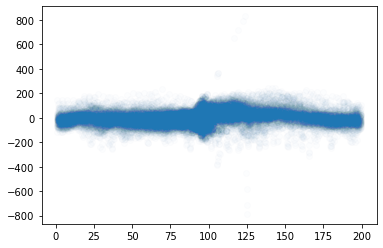

In [121]:
plt.scatter(new_data.iloc[0].spikes_per50ms[2],new_data.iloc[0].spikes_per50ms[3],alpha=0.01)

In [122]:
pos_data

,x_position_cm,time_seconds,speed_per200ms,trial_number,trial_type
0,183.00,0.000,0.000000,1,1
30,182.75,0.001,0.000000,1,1
60,182.75,0.002,0.000000,1,1
90,183.00,0.003,0.000000,1,1
120,182.75,0.004,0.000000,1,1
...,...,...,...,...,...
52304760,0.00,1743.492,0.006615,227,0
52304790,0.00,1743.493,0.000417,227,0
52304820,0.00,1743.494,0.000000,227,0
52304850,0.00,1743.495,0.000000,227,0


In [123]:
session=new_data.iloc[0].session_id
new_data.to_pickle(f"{session}_50ms.pkl",)

In [12]:
session

'M3_D18_2020-11-21_14-29-49'

# Serialize

In [92]:
cohorts = glob.glob("Cohort*")
cohort = cohorts[0]
cohort

'Cohort7_october2020'

In [124]:
mice = glob.glob(f"{cohort}/M*")

#setup kernel
bin_size=50
w=4
f = np.linspace(-5*w,5*w,10*w-1)
K = 1/(np.sqrt(2*np.pi) * w )*np.exp(-f**2/(2*w**2))

for mouse in tqdm.tqdm(mice):
    pos_data = pd.read_pickle(f'{mouse}/position_data.pkl')
    fr_data = pd.read_pickle(f'{mouse}/spatial_firing.pkl')
    
    assert pos_data.index.start==0
    data4copula = [[] for i in range(len(fr_data))]
    for cluster in range(len(fr_data)):
        when, count = np.unique((fr_data.iloc[cluster].firing_times.astype("int")//(pos_data.index.step*bin_size)),return_counts=True)
        spikes = np.zeros(len(pos_data.speed_per200ms[::bin_size])).astype("int")
        spikes[when] = count
        rate = np.zeros(len(pos_data.speed_per200ms[::bin_size])).astype("float")
        rate = np.convolve(spikes,K,mode="same")
    #     pos_data["spikes_per200ms"] = spikes
        data4copula[cluster] = [rate,
                                np.array(pos_data.speed_per200ms[::bin_size]),
                                np.array(pos_data.x_position_cm[::bin_size]),
                                np.diff(pos_data.speed_per200ms)[::bin_size]*1e3,
                                np.array(pos_data.trial_number[::bin_size]),
                                np.array(pos_data.trial_type[::bin_size])]
    # fr_data["spikes_per200ms"]=data4copula
    new_data=pd.DataFrame({"session_id": fr_data.session_id, 
                       'cluster_id': fr_data.cluster_id, 
                       "spikes_per50ms": data4copula})
    if len(fr_data.session_id)==0:
        print(mouse)
        pass
    else:
        session=new_data.iloc[0].session_id
        new_data.to_pickle(f"unified_binned/{cohort}/{session}_50ms.pkl",)

  0%|          | 0/119 [00:00<?, ?it/s]

Cohort7_october2020/M7_D33_2020-12-12_15-39-40
Cohort7_october2020/M4_D2_2020-10-30_15-23-49
Cohort7_october2020/M4_D25_2020-11-30_15-49-06
Cohort7_october2020/M4_D4_2020-11-01_14-53-03
Cohort7_october2020/M4_D21_2020-11-26_15-33-37
Cohort7_october2020/M4_D24_2020-11-29_15-42-16
Cohort7_october2020/M7_D10_2020-11-09_16-16-06
Cohort7_october2020/M4_D29_2020-12-06_15-53-34
Cohort7_october2020/M4_D7_2020-11-06_14-58-44
Cohort7_october2020/M4_D3_2020-10-31_14-46-29
Cohort7_october2020/M4_D20_2020-11-23_15-08-48
Cohort7_october2020/M7_D3_2020-10-31_16-01-32
Cohort7_october2020/M4_D1_2020-10-29_14-21-55
Cohort7_october2020/M7_D27_2020-12-04_16-24-48


In [94]:
glob.glob(f"unified_binned/{cohort}/*")

['unified_binned/Cohort7_october2020/M3_D1_2020-10-29_13-45-02_50ms.pkl',
 'unified_binned/Cohort7_october2020/M7_D26_2020-12-03_16-01-44_50ms.pkl',
 'unified_binned/Cohort7_october2020/M3_D24_2020-11-29_15-08-39_50ms.pkl',
 'unified_binned/Cohort7_october2020/M4_D18_2020-11-21_15-04-19_50ms.pkl',
 'unified_binned/Cohort7_october2020/M7_D1_2020-10-29_15-44-22_50ms.pkl',
 'unified_binned/Cohort7_october2020/M3_D22_2020-11-27_15-01-24_50ms.pkl',
 'unified_binned/Cohort7_october2020/M4_D19_2020-11-22_15-21-58_50ms.pkl',
 'unified_binned/Cohort7_october2020/M3_D7_2020-11-06_14-22-53_50ms.pkl',
 'unified_binned/Cohort7_october2020/M7_D12_2020-11-13_16-20-54_50ms.pkl',
 'unified_binned/Cohort7_october2020/M3_D15_2020-11-16_14-21-36_50ms.pkl',
 'unified_binned/Cohort7_october2020/M6_D3_2020-10-31_15-27-13_50ms.pkl',
 'unified_binned/Cohort7_october2020/M7_D22_2020-11-27_16-11-24_50ms.pkl',
 'unified_binned/Cohort7_october2020/M3_D23_2020-11-28_15-13-28_50ms.pkl',
 'unified_binned/Cohort7_octo

In [90]:
glob.glob(f"{mice[33]}/*")

['Cohort7_october2020/M7_D35_2020-12-14_15-48-14/processed_position_data_unsmoothened.pkl',
 'Cohort7_october2020/M7_D35_2020-12-14_15-48-14/position_data.pkl',
 'Cohort7_october2020/M7_D35_2020-12-14_15-48-14/spatial_firing.pkl']